In [1]:
import math
import torch
import gpytorch
import copy
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')

pacific = sea_level_picontrol[dict(time=slice(0, 3))].sel(xt_ocean=slice(20,25), yt_ocean=slice(-40,-35))

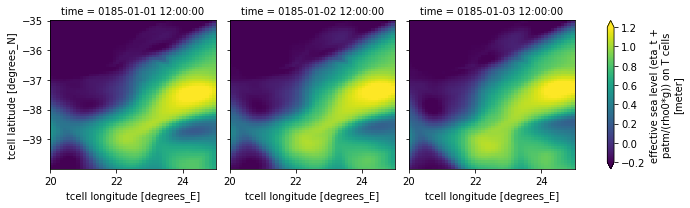

In [42]:
# Plot sea level of selected area
fg = pacific['sea_level'].plot(x="xt_ocean", y="yt_ocean", col="time", col_wrap=3, vmin=-0.2, vmax=1.2)

In [4]:
#Select chunk and remove from training data
sea_df = pacific['sea_level'].to_dataframe().stack().reset_index()
sea_df.drop('level_3', inplace=True, axis=1)
sea_df['time'] = sea_df['time'].apply(lambda x: cf_units.date2num(x,'days since 0185-01-01 12:00:00', calendar='julian'))

training = sea_df[:6300]
testing = sea_df[~sea_df.isin(training)].dropna()

print(training)
print(testing)

      time   yt_ocean  xt_ocean         0
0      0.0 -39.952881     20.05 -0.199586
1      0.0 -39.952881     20.15 -0.211876
2      0.0 -39.952881     20.25 -0.221930
3      0.0 -39.952881     20.35 -0.236669
4      0.0 -39.952881     20.45 -0.256533
...    ...        ...       ...       ...
6295   1.0 -35.037045     24.55 -0.273759
6296   1.0 -35.037045     24.65 -0.246767
6297   1.0 -35.037045     24.75 -0.201573
6298   1.0 -35.037045     24.85 -0.139604
6299   1.0 -35.037045     24.95 -0.070345

[6300 rows x 4 columns]
      time   yt_ocean  xt_ocean         0
6300   2.0 -39.952881     20.05 -0.110183
6301   2.0 -39.952881     20.15 -0.140399
6302   2.0 -39.952881     20.25 -0.154738
6303   2.0 -39.952881     20.35 -0.168066
6304   2.0 -39.952881     20.45 -0.181003
...    ...        ...       ...       ...
9445   2.0 -35.037045     24.55 -0.269282
9446   2.0 -35.037045     24.65 -0.238791
9447   2.0 -35.037045     24.75 -0.190786
9448   2.0 -35.037045     24.85 -0.126817
9449   2.

In [5]:
# Formats sea level data to be compatible with tensor
def format_sea_level(data):
    formatted = []
    for i in range(len(data)):
        formatted.append(data[i])
    
    return torch.FloatTensor((np.array(formatted)).astype(float)).squeeze()

# Set training and testing y's
train_y = format_sea_level(np.array(training[0]))
test_y = format_sea_level(np.array(testing[0]))

In [6]:
# Set training and testing x's
train_x = torch.tensor(np.vstack((training['time'], training['yt_ocean'], training['xt_ocean'])).T).squeeze()
test_x = torch.tensor(np.vstack((testing['time'], testing['yt_ocean'], testing['xt_ocean'])).T).squeeze()
print(train_x.shape)

torch.Size([6300, 3])


In [7]:
# Calculate mean std of x and y variables
ytrain_mean = train_y.mean()
ytrain_std = train_y.std()

ytest_mean = test_y.mean()
ytest_std = test_y.std()

# Normalize training data
train_y = ((train_y - train_y.mean()) / train_y.std())

# Normalize testing data
test_y = (test_y - test_y.mean()) / test_y.std()

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


# hypers = {
#     'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
# }

# model.initialize(**hypers)

# print(
#     model.covar_module.base_kernel.lengthscale.item(),
# )


In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
        
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()


/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=3150
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
delta_y = torch.abs(pred_labels - test_y).detach().numpy()

/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [13]:
# Unnormalize Data
train_y = (train_y * ytrain_std) + ytrain_mean
test_y = (test_y * ytest_std) + ytest_mean
train_pred = (train_pred * ytrain_std) + ytrain_mean
pred_labels = (pred_labels * ytrain_std) + ytrain_mean

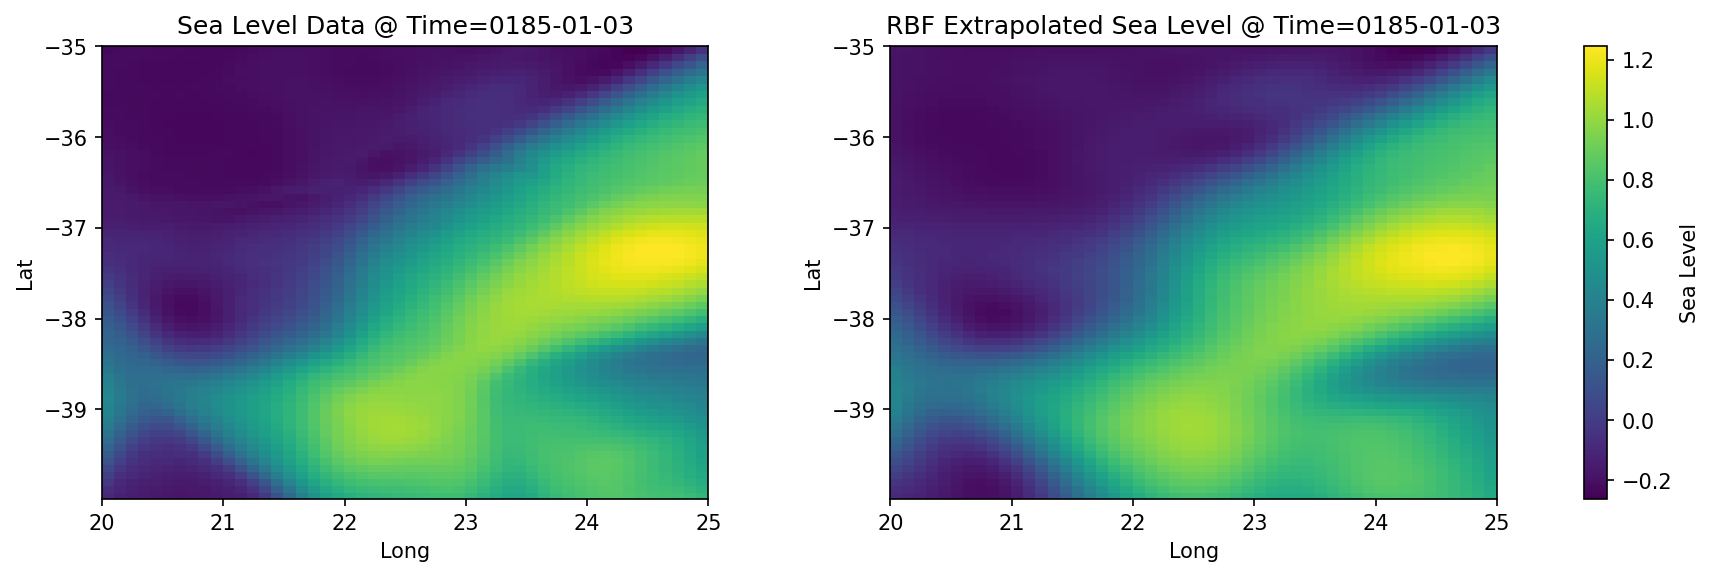

In [15]:
# Plot True Sea Level Data and GP Prediction
test_X_1, test_X_2 = np.meshgrid(test_x[:,2].unique(),test_x[:,1].unique())
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(15, 4))
plt.subplots_adjust(wspace=0.3)

ax[0].pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), shading='auto') 
ax[0].set_title("Sea Level Data @ Time=0185-01-03")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].pcolormesh(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape), shading='auto')
ax[1].set_title("RBF Extrapolated Sea Level @ Time=0185-01-03")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
cbar = fig.colorbar(contour_, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

plt.show()

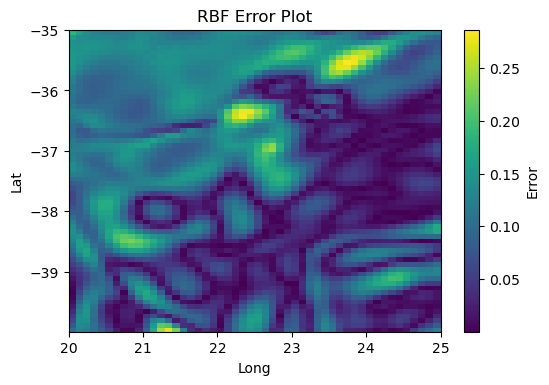

In [16]:
# Plot error
train_X_1, train_X_2 = np.meshgrid(test_x[:,2].unique(),test_x[:,1].unique())

plt.figure(dpi=100, figsize=(6, 4))
plt.pcolormesh(train_X_1, train_X_2,
             delta_y.reshape(train_X_2.shape), shading='auto')
plt.title("RBF Error Plot")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Error')
plt.show()

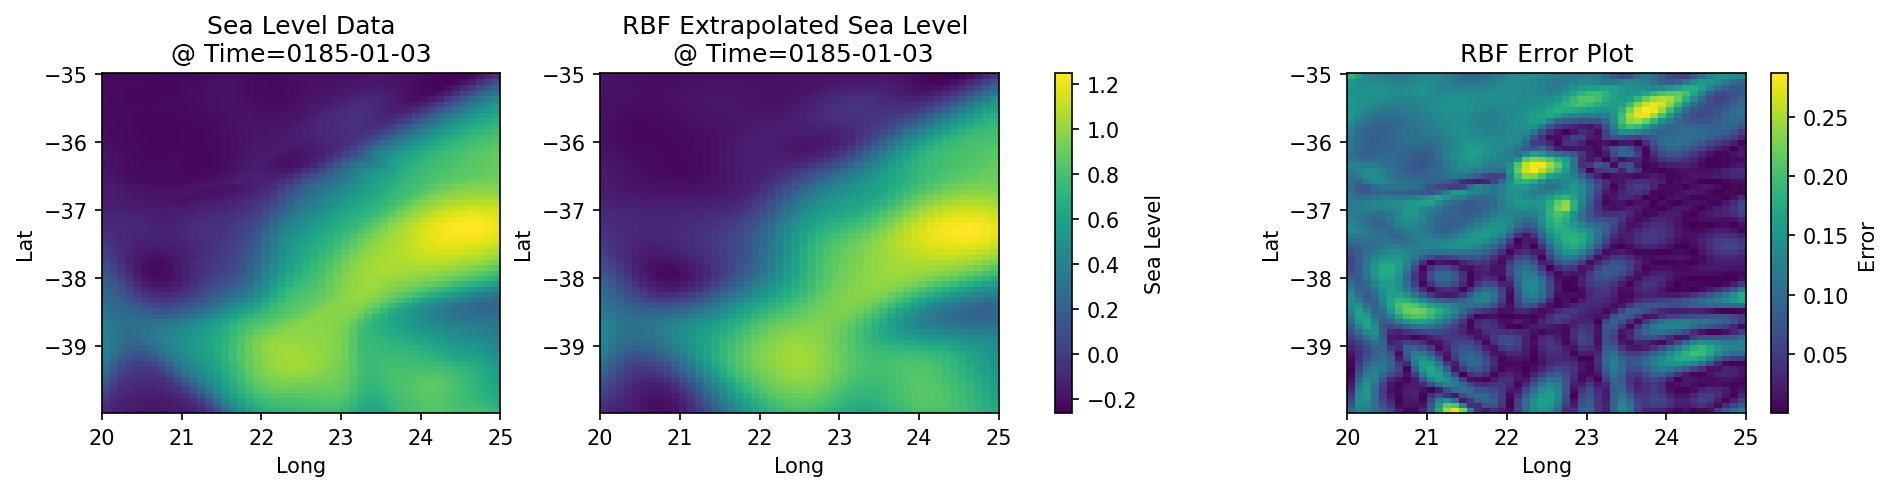

In [39]:

# Plot True Sea Level Data, GP Prediction, and Error
test_X_1, test_X_2 = np.meshgrid(test_x[:,2].unique(),test_x[:,1].unique())

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(15, 3))
plt.subplots_adjust(wspace=0.25)

ax[0].pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), shading='auto') 
ax[0].set_title("Sea Level Data\n@ Time=0185-01-03")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].pcolormesh(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape),  shading='auto')
ax[1].set_title("RBF Extrapolated Sea Level \n @ Time=0185-01-03")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")

error_ = ax[2].pcolormesh(test_X_1, test_X_2,
             delta_y.reshape(test_X_2.shape), shading='auto')
ax[2].set_title("RBF Error Plot")
ax[2].set_xlabel("Long")
ax[2].set_ylabel("Lat")

cbar = fig.colorbar(contour_, ax=ax[0:2].ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

cbar_e = fig.colorbar(error_, ax=ax[2])
cbar_e.ax.set_ylabel('Error')


plt.show()